## Eunjoo and Eryk's Housing Price Bakery

Baking King County's sweetest housing price desserts since 2014.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import scipy.stats as st
import math

import pickle

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.stattools import jarque_bera

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Step 1: Read in Data

In [2]:
house_train = pd.read_csv('data/kc_house_data_train.csv', index_col = 0)
#house_train.head()

In [3]:
#house_train.info()

## Step 2: Exploratory Data Analysis 
    
Become familiar with the data.  Look to see if there are any extreme values.  

Additionally create data visualizations to determine if there are any relationships between your features and your target variables.  

In [4]:
##  take logs
house_train['ln_price'] = np.log(house_train['price'])
house_train['ln_sqft_living'] = np.log(house_train['sqft_living'])
house_train['ln_sqft_living15'] = np.log(house_train['sqft_living15'])
house_train['ln_sqft_lot'] = np.log(house_train['sqft_lot'])
house_train['ln_sqft_lot15'] = np.log(house_train['sqft_lot15'])
house_train['ln_sqft_above'] = np.log(house_train['sqft_above'])
house_train['ln_sqft_basement'] = np.where(house_train['sqft_basement']==0,0,
                                           np.log(house_train['sqft_basement']))

In [5]:
# for each columns, plot scatter plot
def mass_scatter(df, y = 'ln_price'):
    a = len(df.columns)
    ncols = math.ceil(a**.5)
    nrows = math.ceil(a/ncols)
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (12, 15))

    axes = axes.ravel()

    for i in range(len(df.columns)):
        axes[i].scatter(df.iloc[:, i], df[y], alpha = 0.2)
        axes[i].set_title(df.columns[i])
        axes[i].get_yaxis().set_ticks([])

In [6]:
cols_int = ['bedrooms','bathrooms','floors',
            'waterfront','view',
            'condition','grade',
            'yr_built',## 'yr_renovated',
            'lat', 'long',  
            'ln_sqft_living',## 'ln_sqft_living15', 
            'ln_sqft_lot',## 'ln_sqft_lot15',
            'ln_sqft_above','ln_sqft_basement']

#mass_scatter(house_train[cols_int + ['ln_price']])

### Observation
#### Outliers
1. There is one outlier that has extremely many bedroom. 
2. Some price points are very high and weakening relationships, we should take a look at them.
3. There's a very large lot in the data set. We should check that's not an outlier.

#### Missing Info
1. Location is a valuable information. We have zipcode and long/lat to approximate the location info. 
- Add zipcode in as categorical and filter out to ones that matter. 
- Make an interaction of long/lat as a feature
2. Year renovated is perhaps important feature but is not applicable for most datapoints. We should create a new variable 'year_old' that counts the age of the house. Check interaction of this with Condition variable.
3. Basement - it seems like many are missing basement value. So I'll create a binary column for whether basement exist or not and add in as a feature.

### Outliers
#### 1. too many bedroom
There's a house with 30+ bedrooms. Let's take a look at that.

In [7]:
house_train[house_train.bedrooms > 20]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,long,sqft_living15,sqft_lot15,ln_price,ln_sqft_living,ln_sqft_living15,ln_sqft_lot,ln_sqft_lot15,ln_sqft_above,ln_sqft_basement
8597,2402100895,20140625T000000,640000.0,33,1.75,1620,6000,1.0,0,0,...,-122.331,1330,4700,13.369223,7.390181,7.192934,8.699515,8.455318,6.946976,6.363028


It's likely that 33 bedrooms is an input error of 3, since it's a small place with less than 2 bathrooms. We will change that value to more appropriate number.

In [8]:
round((house_train.bedrooms/house_train.sqft_living).median()*1620)

# median # of bedroom per sqft.living multiplied by sqft.living 
house_train.at[8597, 'bedrooms'] = 3

#### 2. Price outliers
Some houses seem to be extremely expensive. Let's take a look.

#### Price distribution

In [9]:
#house_train.boxplot(['price']) 

# some extreme values.
#   EB:  "Maybe we should remove them."
#   EMW: "No way, Jose!  Take logs instead."

In [10]:
#house_train.sort_values(by = 'price', ascending = False)

#### Log Price distribution  

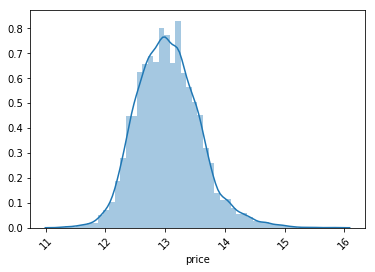

In [11]:
sns.distplot(np.log(house_train.price))
plt.xticks(rotation=45)
plt.show()

In [12]:
# removing outliers with log price value higher than 4 log std.
#log_filt = np.log(house_train.price).mean() + np.log(house_train.price).std()*4
#print(len(house_train[np.log(house_train.price)>= log_filt]))

# not removing it, but here's how to do it:
# house_train = house_train[np.log(house_train.price) < log_filt]

### 3. Large lot

In [13]:
#house_train.sort_values(by = 'sqft_lot', ascending = False)
# it seems like it's a large lot and a very small house. 
# I have no evidence to think this is an error. 
# We will keep it for now.

### Features (New columns)
Now I'll create new columns I need. From here on, I will need to be able to replicate, so I'll create them as a function.

#### Date
I'm not entirely sure what 'date' columns is supposed to be. But we can separate out month and year and see if they have any effect on our model.

In [14]:
def make_dates(df):
    df['month_sold'] = df.date.apply(lambda x: int(x[4:6]))
    df['yr_sold'] = df.date.apply(lambda x: int(x[0:4]))
    df.date = df.date.apply(lambda x: int(x[0:8]))
    df.date = pd.to_datetime(df.date, format = "%Y%m%d")
    return df

house_train = make_dates(house_train)

In [15]:
# change date
# house_train.date = pd.to_datetime(house_train.date, format = "%Y%m%d")

#### Year_old
Either year since renovated or since built

In [16]:
def make_yearold (df):
    df['year_old'] = np.where(df.yr_renovated == 0, df.yr_sold - df.yr_built, df.yr_sold - df.yr_renovated)
    return df
house_train = make_yearold(house_train)

#### Basement
Add a column that shows whether there is a basement or not. 

In [17]:
def make_basement(df):
    df['basement'] = np.where(df.sqft_basement > 0, 1, 0)
    return df

house_train = make_basement(house_train)

## Status Check

In [18]:
##  columns of interest
cols_int = ['bedrooms','bathrooms','floors',
            'waterfront','view',
            'condition','grade',
            'yr_built',## 'yr_renovated',
            'lat', 'long',  
            'ln_sqft_living',## 'ln_sqft_living15', 
            'ln_sqft_lot',## 'ln_sqft_lot15',
            'ln_sqft_above','ln_sqft_basement',
            'month_sold','yr_sold','year_old','basement']

#mass_scatter(house_train[cols_int + ['ln_price']])

## Baseline Model

We will check for assumptions and create a baseline model here. And then we will investigate interactions and other feature selection to see if any improves our model.

### Scale, transform data, and add dummy columns

In [19]:
# sqft_lot seemed to have exponential decay relationship to price. So transferring to log.
# Can't say with confidence that this is linear relationship...???
#plt.scatter(np.log(house_train.ln_sqft_lot), house_train.ln_price, alpha = 0.2);

In [20]:
def dummies(x, prefix):
    """
    Helper function to make dummies
    Input: series or array, prefix string
    Output: dummy dataframe
    """
    dummy = pd.get_dummies(x, prefix = prefix, drop_first = True)
    return dummy

In [21]:
def standardize(x):
    """
    Helper function to standardize scalar values
    Input: series or numpy array 
    Output: original input as standardized version ((x-mean(x))/std(x))
    """
    return (x - x.mean())/x.std()

In [22]:
def remove_feat(df, exc_list):
    df.drop(exc_list, axis = 1, inplace = True)
    return df

In [23]:
##  turn categorical variables into dummy variables
zp_df = dummies(house_train['zipcode'],'zip')
mo_df = dummies(house_train['month_sold'],'mo_sold')
yr_df = dummies(house_train['yr_sold'],'yr_sold')

# ##  add them to dataframe
house_train = house_train.join(zp_df)
house_train = house_train.join(mo_df)
house_train = house_train.join(yr_df)

# ##  get lists of variable names
zp_dummies = list(zp_df.columns)
mo_dummies = list(mo_df.columns)
yr_dummies = list(yr_df.columns)

### Check for multicollinearity

In [24]:
def corr_high(df):
    corr_df = abs(df.corr()).stack().reset_index()
    corr_df.columns = ['var1', 'var2', 'corr']
    return corr_df[(corr_df['corr'] > 0.6) & (corr_df['corr'] < 1)].sort_values(by = 'corr', ascending = False)

In [25]:
cols_int = ['bedrooms','bathrooms','floors',
            'waterfront','view',
            'condition','grade',
            'yr_built',
            'lat', 'long',  
            'ln_sqft_living',
            'ln_sqft_lot',
            'ln_sqft_above','ln_sqft_basement']

corr_high(house_train[cols_int])

,var1,var2,corr
152,ln_sqft_living,ln_sqft_above,0.864497
178,ln_sqft_above,ln_sqft_living,0.864497
24,bathrooms,ln_sqft_living,0.761053
141,ln_sqft_living,bathrooms,0.761053
96,grade,ln_sqft_above,0.745496
174,ln_sqft_above,grade,0.745496
94,grade,ln_sqft_living,0.744542
146,ln_sqft_living,grade,0.744542
26,bathrooms,ln_sqft_above,0.694596
169,ln_sqft_above,bathrooms,0.694596


### Remove features

In [26]:
##  Why remove anything?  Just ignore it!  
#exc_list = ['sqft_living', 'sqft_lot15', 'sqft_living15', 'con_4']
#X = remove_feat(X, exc_list)

### Run baseline model


In [27]:
cols_int = ['bedrooms','bathrooms','floors','basement',
            'waterfront','view',
            'condition','grade',
            'yr_built',
            'lat', 'long',  
            'ln_sqft_living',
            'ln_sqft_lot']#,
            #'ln_sqft_basement']
#cols_int = cols_int + zp_dummies

m01_fmla = 'ln_price~' + '+'.join(cols_int)
m01_ols = ols(m01_fmla,data=house_train).fit()
m01_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     4310.
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        16:57:33   Log-Likelihood:                -958.00
No. Observations:               17290   AIC:                             1944.
Df Residuals:                   17276   BIC:                             2053.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -41.7957      2.305    -18.129      0.000     -46.315     -37.277
bedrooms          -0.0281      0.003     -9.723      0.000      -0.034      -0.022
bathrooms          0.0712      0.005     15.698      0.000       0.062       0.080
floors             0.0506      0.005      9.555      0.000       0.040       0.061
basement           0.0052      0.005      1.040      0.298      -0.005       0.015
waterfront         0.3933      0.024     16.370      0.000       0.346       0.440
view               0.0707      0.003     24.114      0.000       0.065       0.076
condition          0.0547      0.003     16.806      0.000       0.048       0.061
grade              0.1853      0.003     65.781      0.000       0.180       0.191
yr_built          -0.0038   9.61e-05    -39.270      0.000      -0.004      -0.004
lat                1.3414      0.015     89.711      0.000       1.312       1.371
long               0.0519      0.017      3.037      0.002       0.018       0.085
ln_sqft_living     0.4123      0.010     39.852      0.000       0.392       0.433
ln_sqft_lot       -0.0049      0.003     -1.736      0.083      -0.010       0.001
==============================================================================
Omnibus:                      445.117   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              903.190
Skew:                           0.164   Prob(JB):                    7.50e-197
Kurtosis:                       4.071   Cond. No.                     2.34e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.34e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
cols_int = ['bedrooms','bathrooms','floors','basement',
            'waterfront','view',
            'condition','grade',
            'yr_built',
            'lat', 'long',  
            'ln_sqft_living',
            'ln_sqft_lot']#,
            #'ln_sqft_basement']
cols_int = cols_int + zp_dummies

m03_fmla = 'ln_price~' + '+'.join(cols_int)
m03_ols = ols(m03_fmla,data=house_train).fit()
m03_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     1542.
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        16:57:34   Log-Likelihood:                 4891.0
No. Observations:               17290   AIC:                            -9616.
Df Residuals:                   17207   BIC:                            -8972.
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -74.7519      7.767     -9.624      0.000     -89.976     -59.527
bedrooms          -0.0177      0.002     -8.441      0.000      -0.022      -0.014
bathrooms          0.0462      0.003     14.163      0.000       0.040       0.053
floors            -0.0035      0.004     -0.859      0.390      -0.011       0.004
basement          -0.0461      0.004    -12.375      0.000      -0.053      -0.039
waterfront         0.4726      0.017     27.096      0.000       0.438       0.507
view               0.0653      0.002     30.281      0.000       0.061       0.070
condition          0.0436      0.002     18.252      0.000       0.039       0.048
grade              0.1084      0.002     50.100      0.000       0.104       0.113
yr_built          -0.0005   7.97e-05     -6.451      0.000      -0.001      -0.000
lat                0.5574      0.080      6.943      0.000       0.400       0.715
long              -0.4655      0.057     -8.107      0.000      -0.578      -0.353
ln_sqft_living     0.4540      0.008     60.151      0.000       0.439       0.469
ln_sqft_lot        0.0664      0.002     28.404      0.000       0.062       0.071
zip_98002          0.0129      0.019      0.696      0.487      -0.023       0.049
zip_98003         -0.0186      0.017     -1.129      0.259      -0.051       0.014
zip_98004          1.0099      0.030     33.756      0.000       0.951       1.069
zip_98005          0.6123      0.032     19.351      0.000       0.550       0.674
zip_98006          0.5813      0.026     22.312      0.000       0.530       0.632
zip_98007          0.5471      0.033     16.817      0.000       0.483       0.611
zip_98008          0.5639      0.031     18.105      0.000       0.503       0.625
zip_98010          0.3368      0.029     11.816      0.000       0.281       0.393
zip_98011          0.2485      0.040      6.139      0.000       0.169       0.328
zip_98014          0.2724      0.044      6.131      0.000       0.185       0.360
zip_98019          0.2345      0.044      5.346      0.000       0.149       0.320
zip_98022          0.2094      0.024      8.627      0.000       0.162       0.257
zip_98023         -0.0635      0.015     -4.203      0.000      -0.093      -0.034
zip_98024          0.4582      0.039     11.745      0.000       0.382       0.535
zip_98027          0.5126      0.027     19.176      0.000       0.460       0.565
zip_98028          0.1904      0.039      4.820      0.000       0.113       0.268
zip_98029          0.5981      0.031     19.554      0.000       0.538       0.658
zip_98030          0.0541      0.018      2.975      0.003       0.018       0.090
zip_98031          0.0594      0.019      3.141      0.002       0.022       0.097
zip_98032         -0.0507      0.022     -2.340      0.019      -0.093      -0.008
zip_98033   

In [29]:
# adding zipcodes helps
m01_r2 = m01_ols.rsquared
m03_r2 = m03_ols.rsquared

print('R^2 m01:  ' +str(round(m01_r2,4)))
print('R^2 m03:  ' +str(round(m03_r2,4)))

R^2 m01:  0.7643
R^2 m03:  0.8802


###  save model as `X3` and `yy`

In [30]:
##  save model as "X3" and "yy"
X3 = house_train[cols_int]
yy = house_train['ln_price']

In [31]:
import numpy as np
np.exp(1)

2.718281828459045

## Step 5: Train Test Split

If you plan on doing any sclaing of your data, make sure it is doen at the apporpriate time. 

Since we will be re-running this process again, I'll write it as a function.  

In [32]:
def lin_avg_crossval(X, y):
    regression = LinearRegression()
    crossvalidation = KFold(n_splits=3, shuffle=True, random_state=1)
    
    return np.mean(cross_val_score(regression, X, y, scoring='r2', cv=crossvalidation))

def lin_fit(X, y):
    lm = LinearRegression(normalize = True)
    lm = lm.fit(X, y)

    print(f"R2: {lm.score(X, y)}")
    print(f"Adj_R2: {1 - (1-lm.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)}")

    return lm

### 5.1) Perform a train test split of the data.

In [33]:
# function to split the data 
def split_df (X, y, test_size = 0.25, random_state = 42):
    """
    input: df and name of outcome column
    return: train, test for x and y
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

### 5.4) Fit the model to the training data.

In [34]:
def test_train_split(X, y, test_size = 0.25, random_state = 42):
    """
    split the data and fit model
    return y_train, y_test, y_pred_train, y_pred_test, print prediction errors
    """
    X_train, X_test, y_train, y_test = split_df(X, y, test_size, random_state)
    linreg = LinearRegression()

    linreg.fit(X_train, y_train)
    
    exp_y_train = np.exp(y_train)
    exp_y_test = np.exp(y_test)
    exp_y_pred_train = np.exp(linreg.predict(X_train))
    exp_y_pred_test = np.exp(linreg.predict(X_test))
    
    train_mse = mean_squared_error(exp_y_train, exp_y_pred_train)
    test_mse = mean_squared_error(exp_y_test, exp_y_pred_test)
    
    print('Train RMSE:', np.sqrt(train_mse))
    print('Test RMSE:', np.sqrt(test_mse))

    return X_train, X_test, exp_y_train, exp_y_test, exp_y_pred_train, exp_y_pred_test

In [35]:
x_train, x_test, y_train, y_test, y_pred_train, y_pred_test = test_train_split(X3, yy)

Train RMSE: 129828.38355124311
Test RMSE: 135956.87688252793


### 5.7) Determine if your model is overfit.

Text(0.5, 0, 'RMSE')

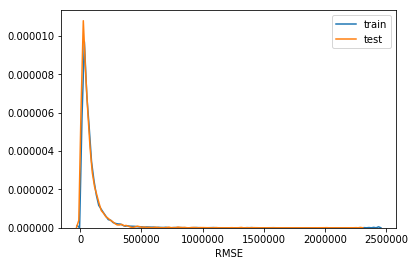

In [36]:
sns.distplot(np.sqrt((y_train-y_pred_train)**2), hist = False, label = 'train')
sns.distplot(np.sqrt((y_test-y_pred_test)**2), hist = False, label = 'test')
plt.xlabel("RMSE")

## Step 6: Utilize some different feature selection techniques before or in conjuction with fitting your models

### 6.1) Utilize a filter method to identify some features to remove from the model.  

### Comparing MSE

Train RMSE: 129828.38355124311
Test RMSE: 135956.87688252793


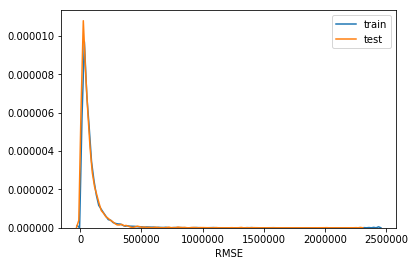

In [37]:
Xs = [ X3 ]

for x in Xs:
    x_tr, x_te, y_train, y_test, y_pred_train, y_pred_test = test_train_split(x, yy)
    sns.distplot(np.sqrt((y_train-y_pred_train)**2), hist = False, label = 'train')
    sns.distplot(np.sqrt((y_test-y_pred_test)**2), hist = False, label = 'test')
    plt.xlabel("RMSE")
    plt.show()

Train RMSE: 129828.38355124311
Test RMSE: 135956.87688252793
TRAIN
R2: 0.7684678460347949
Adj_R2: 0.7669942635584562
TEST
R2: 0.7650964025577296
Adj_R2: 0.760553455626063


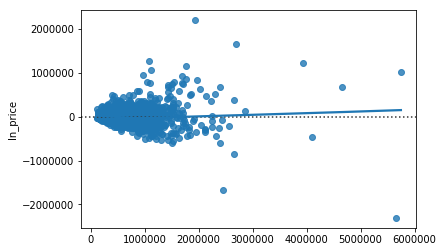

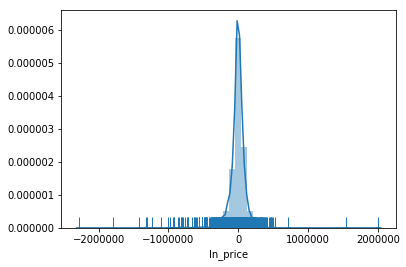

NormaltestResult(statistic=3154.238696669907, pvalue=0.0)
NormaltestResult(statistic=9343.950250040327, pvalue=0.0)
[('Jarque-Bera', 549923.3984931577), ('Prob', 0.0), ('Skew', -2.5464312237369984), ('Kurtosis', 58.018838573650775)]


In [38]:
for x in Xs:
    x_train, x_test, y_train, y_test, y_pred_train, y_pred_test = test_train_split(x, yy)
    print("TRAIN")
    lm = lin_fit(x_train, y_train) 
    print("TEST")
    lm = lin_fit(x_test, y_test)
    
    # look at variance
    sns.residplot(y_pred_test, y_test, lowess = True)
    plt.show()
    
    #normality
    sns.distplot((y_pred_test - y_test), kde = True, rug = True)
    plt.show()

    print(st.normaltest(y_pred_test - y_test))
    print(st.normaltest(y_pred_train - y_train))

    name = ['Jarque-Bera', 'Prob', 'Skew', 'Kurtosis']
    test = jarque_bera(y_pred_test - y_test)
    print(list(zip(name, test)))


## Step 7: Evaluate your different models in order to determine the best model overall

Train RMSE: 129828.38355124311
Test RMSE: 135956.87688252793


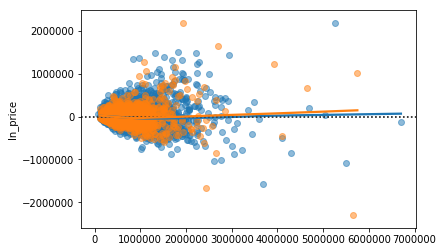

In [39]:
X_train, X_test, y_train, y_test, y_pred_train, y_pred_test = test_train_split(X3, yy)

sns.residplot(y_pred_train, y_train, lowess = True, scatter_kws = {'alpha':0.5})
sns.residplot(y_pred_test, y_test, lowess = True, scatter_kws = {'alpha':0.5})


It's not overfitting, but it does seem like residuals are heteroscedastic.

## Step 8:  Refit your best model to the entire dataset

In [40]:
model = lin_fit(X3, yy)

R2: 0.8802033577201551
Adj_R2: 0.8796324665324439


## Step 9: Save your final model using pickle

https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

In [41]:
filename = 'model_eb-emw-v3b.sav'
pickle.dump(model, open(filename, 'wb'))